# Homework #7

Carina Cheng

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

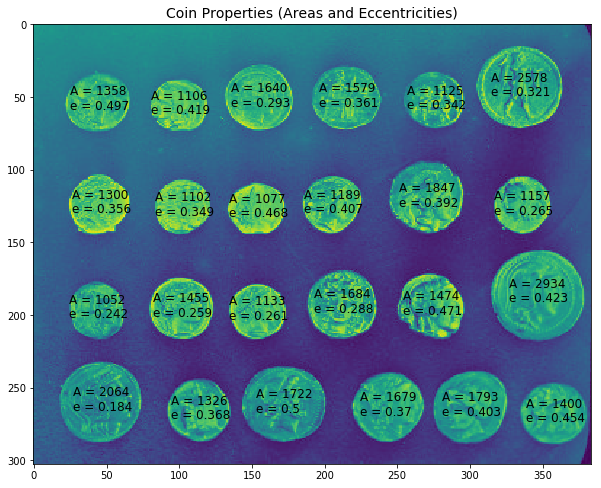

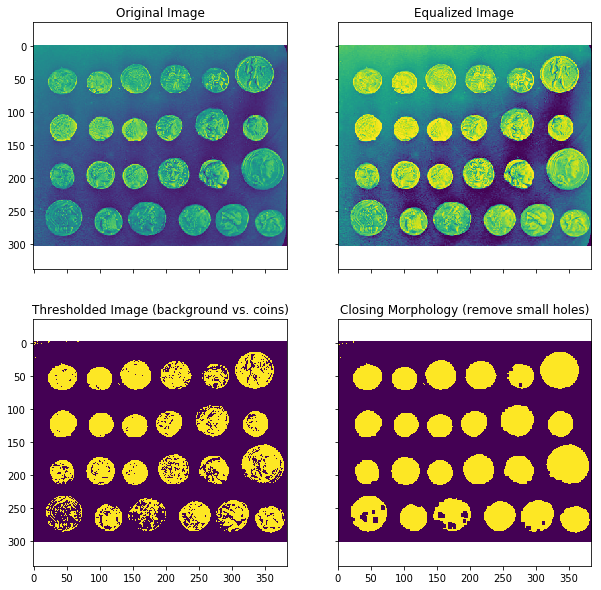

In [1]:
%matplotlib inline
from skimage import data
from skimage import exposure
from skimage import filters
from skimage import segmentation
from skimage import morphology
from skimage import measure
from skimage import color
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np

# Load image
image = data.coins()

# Equalize
image_eq = exposure.equalize_hist(image)

# Threshold
thresh = filters.threshold_otsu(image_eq)
thresh += 0.25 # need to increase threshold to remove all the background
coins = (image_eq >= thresh)
background = (image_eq < thresh)
image_thresh = coins

# Remove objects touching boundaries
labels_clear = segmentation.clear_border(coins)
image_bound = image_thresh * labels_clear

# Morphological closing
image_close = morphology.closing(image_bound, morphology.square(5))

# Find coin regions
labels = label(image_close)
regions = measure.regionprops(labels)
image_label_overlay = color.label2rgb(labels, image=image_close)
#plt.imshow(image_label_overlay)
#plt.show()

# Set-up plot that will contain original image and information
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image) # original image
for region in regions: 
    if region.area > 100: # only if a coin region (large regions)
        ax.text((region.bbox[3]+region.bbox[1])/2 - 20,(region.bbox[2]+region.bbox[0])/2 - 5,
                'A = '+str(region.area), fontsize=12)
        ax.text((region.bbox[3]+region.bbox[1])/2 - 20,(region.bbox[2]+region.bbox[0])/2 + 5,
                'e = '+str(np.round(region.eccentricity,3)), fontsize=12)
ax.set_title("Coin Properties (Areas and Eccentricities)", fontsize=14)
plt.show()
        
# Plot different stages of image processing
f, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10,10))
ax1.imshow(image)
ax1.set_title("Original Image")
ax2.imshow(image_eq)
ax2.set_title("Equalized Image")
ax3.imshow(image_thresh)
ax3.set_title("Thresholded Image (background vs. coins)")
ax4.imshow(image_close)
ax4.set_title("Closing Morphology (remove small holes)")
plt.show()

## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

Original 3 Images:


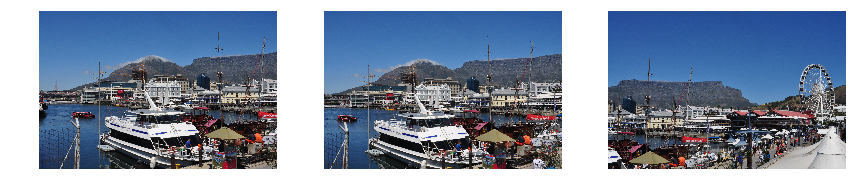

Feature matching between left & middle panels:


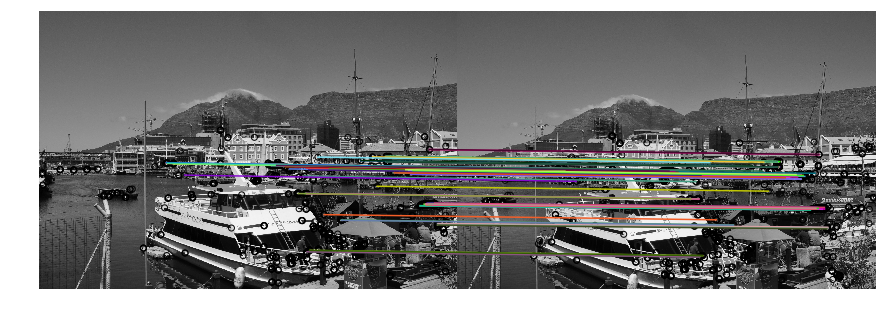

Feature matching between middle & right panels:


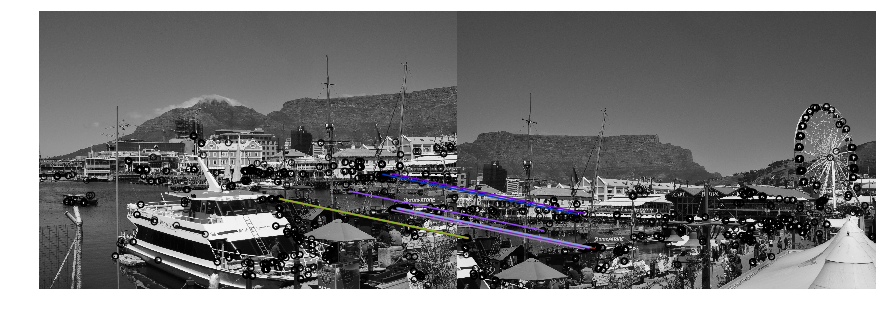

Warped Images:


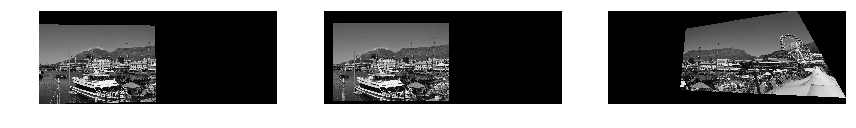

Images with Minimum Cost Path Masks:


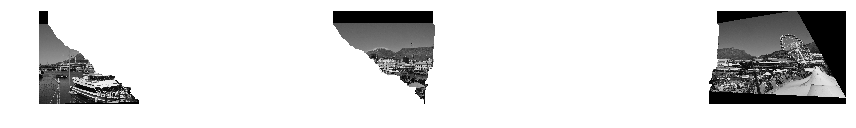

Stitched Panorama (Cape Town, South Africa):


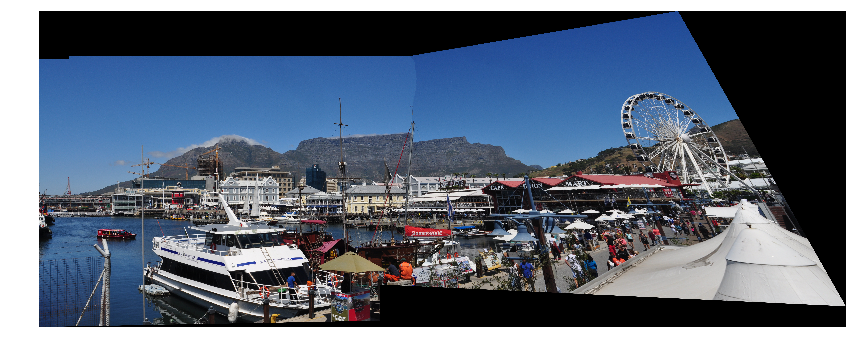

In [1]:
# Note: most code adapted from: https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb
# Some comments added by me

%matplotlib inline
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.feature import plot_matches
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.measure import label
from skimage.graph import route_through_array
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.): 
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True: # transpose if not vertical orientation
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

def compare(*images, **kwargs): 
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()
    plt.show()

def add_alpha(img, mask=None): 
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img) # convert gray image to RGB color image
    
    return np.dstack((img, mask))

#--------------------------------------------------------------------

# Load images
#pano_imgs = io.ImageCollection('JDW_03*') # images from tutorial
pano_imgs = io.ImageCollection('capetown*') # my images
print("Original 3 Images:")
compare(*pano_imgs, figsize=(12, 10)) # plot original images side-by-side

# Pre-processing
pano0, pano1, pano2 = [rgb2gray(im) for im in pano_imgs] # convert from color to grayscale 
#compare(pano0, pano1, pano2, figsize=(12, 10)) # plot images side-by-side

# Detect features
orb = ORB(n_keypoints=800, fast_threshold=0.05) # Oriented FAST and rotated BRIEF features
orb.detect_and_extract(pano0) # pano0
keypoints0 = orb.keypoints # keypoint coordinates
descriptors0 = orb.descriptors # binary array designating where keypoints are
orb.detect_and_extract(pano1) # pano1
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors
orb.detect_and_extract(pano2) # pano2
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

# Match descriptors between left/right images and the center
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True) # returns matches between pano0 & pano1
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True) # returns matches between pano1 & pano2

# Plot best match subset for pano0 -> pano1
#fig, ax = plt.subplots(1, 1, figsize=(15, 12))
#plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01)
#ax.axis('off');

# Plot best match subset for pano2 -> pano1
#fig, ax = plt.subplots(1, 1, figsize=(15, 12))
#plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12)
#ax.axis('off');

# Filter out false matches ------------------------------------------

src = keypoints0[matches01[:, 0]][:, ::-1] # keypoint matches (coordinates) from pano0
dst = keypoints1[matches01[:, 1]][:, ::-1] # keypoint matches (coordinates) from pano1 (anchor pano)
model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300) # finds robust matches (inliers)

src = keypoints2[matches12[:, 1]][:, ::-1] # keypoint matches (coordinates) from pano2
dst = keypoints1[matches12[:, 0]][:, ::-1] # keypoint matches (coordinates) from pano1 (anchor pano)
model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300) # finds robust matches (inliers)

# Plot best match subset for pano0 -> pano1
print("Feature matching between left & middle panels:")
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])
ax.axis('off'); plt.show()

# Plot best match subset for pano2 -> pano1
print("Feature matching between middle & right panels:")
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])
ax.axis('off'); plt.show()

# Warping ------------------------------------------

# Shape of middle, anchor image
r, c = pano1.shape[:2] # row, column

# Corner coordinates
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions based on the robust matches
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of all corners in all images
all_corners = np.vstack((warped_corners01, warped_corners12, corners))
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min) # overall output shape will be max - min
output_shape = np.ceil(output_shape[::-1]).astype(int) # ensure integer shape with np.ceil and dtype conversion

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min) # translate image to match minimum corner

# Translate pano1 into place (warp based on coordinate transformation [the function takes the inverse])
pano1_warped = warp(pano1, offset1.inverse, order=3, # order of interpolation
                    output_shape=output_shape, cval=-1) # -1 is outside the image

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

# Warp pano0 (left) to pano1
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

# Warp pano2 (right) to pano1 
transform12 = (model_robust12 + offset1).inverse
pano2_warped = warp(pano2, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0

print("Warped Images:")
compare(pano0_warped, pano1_warped, pano2_warped, figsize=(12, 10)); # plot warped images side-by-side

# Stitching via Minimum-Cost Vertical Path ------------------------------------------
# This method finds the path of least differences between two images and this path is used to stitch the images together

ymax = output_shape[1] - 1 # indices of seed points
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

# First first cost path (between pano0 & pano1)
costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)

# Set top and bottom edges to zero cost
costs01[0,  :] = 0
costs01[-1, :] = 0

# Find route
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True) # cost array, start point, end point
pts = np.array(pts)

# Plot the difference image
#fig, ax = plt.subplots(figsize=(12, 12))
#ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Turn the path into a mask
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1
mask0 = (label(mask0, connectivity=1, background=-1) == 1)

# Find second cost path (between pano1 & pano2)
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

# Set top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

costs12[mask0 > 0] = 1 # prevent path-crossing

# Find route
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)
pts = np.array(pts)

# Turn the path into a mask
mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1
mask2 = (label(mask2, connectivity=1, background=-1) == 3)

# Combine masks into a final mask
mask1 = ~(mask0 | mask2).astype(bool)

pano0_final = add_alpha(pano0_warped, mask0)
pano1_final = add_alpha(pano1_warped, mask1)
pano2_final = add_alpha(pano2_warped, mask2)

print("Images with Minimum Cost Path Masks:")
compare(pano0_final, pano1_final, pano2_final, figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
#fig, ax = plt.subplots(figsize=(12, 12))
#ax.imshow(pano0_final, interpolation='none')
#ax.imshow(pano1_final, interpolation='none')
#ax.imshow(pano2_final, interpolation='none')
#fig.tight_layout()
#ax.axis('off');

# Add back in color
pano0_color = warp(pano_imgs[0], (model_robust01 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano1_color = warp(pano_imgs[1], offset1.inverse, order=3,
                   output_shape=output_shape, cval=0)

pano2_color = warp(pano_imgs[2], (model_robust12 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano0_final = add_alpha(pano0_color, mask0)
pano1_final = add_alpha(pano1_color, mask1)
pano2_final = add_alpha(pano2_color, mask2)

# Plot final panorama in color
print("Stitched Panorama (Cape Town, South Africa):")
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')
fig.tight_layout()
ax.axis('off');

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.